In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pickle
from scipy.special import expit

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
# Simulation info Global Parameters 
sim_blocks = 4
sim_trials = 16
sim_sessions = 2

In [74]:
from scipy.special import expit

samples = 2000 # how many samples in total per chain?
warmup = 1500 # how many warmup samples? these do not contribute to posterior
chains = 4 # how many chains?
thin = 1 # period for saving samples
n_jobs = 4 # how many cores?

samplingInfo = dict(samples=samples, warmup=warmup, chains=chains, thin=thin, n_jobs=n_jobs)

def phi_approx(x): # Phi_approx(x) = logit^{-1}(0.07056 x^3 + 1.5976 x)
    return expit(0.07056*(x**3) + 1.5976*x)

In [75]:
import numpy as np
import matplotlib.pyplot as plt


def plotLearningCurve(data, N=10, ifReturnCurveData=False, ifLegend=False):
    
    if ifReturnCurveData:
        curveData=dict()
        for trialType in ['forced','free']:
          for dataName in ['x','y','err']:
            curveData[(trialType, dataName)]=None
    else:
        # plot setting
        from IPython.display import set_matplotlib_formats
        set_matplotlib_formats('png', 'pdf')
        plt.rcParams.update({'font.family': 'arial'})
        lineWidth = 2
        fig, ax = plt.subplots(figsize=(10,3.5))
    
    # create x variable (trial index)
    trialIndices = []
    for i_block in range(n_blocks*2):
        if i_block == 0:
            start = 1
        else:
            start = trialIndices[-2] + (2 if i_block%2 else 1)
        trialIndices = np.concatenate((trialIndices, np.arange(start, start+N), [np.nan]))   
    
    # note that the correct choice for free trials is defined based on block type (which is defined based on detected block change point, can be later than real change point)
    data['correctChoice'] = 1*(data['odor']=='left') + 2*(data['odor']=='right') + (data['odor']=='free')*(
            1*((data['blockType']=='short_long')|(data['blockType']=='big_small')) +
            2*((data['blockType']=='long_short')|(data['blockType']=='small_big')) )
    data['correct'] = (data['correctChoice'] == data['choice'])
    
    for trialType in ['forced','free']:
        learningCurves = []
        for iRat, rat in enumerate(data['rat'].unique()):
            learningCurve = []
            for i_block in np.arange(n_blocks)+1:
                sessions = data.loc[data['rat']==rat,'session'].unique()
                NSessions = sessions.shape[0]
                firstN = np.zeros((NSessions, N))
                lastN = np.zeros((NSessions, N))
                for iter_session in range(NSessions):
                    sessionData = data[(data['rat']==rat) & (data['block']==i_block) & (data['session']==sessions[iter_session]) & (data['trialType']=='valid')]
                    thisFirst, thisLast = getFirstLastNTrials(N, sessionData, trialType)
                    firstN[iter_session, :] = thisFirst
                    lastN[iter_session, :] = thisLast
                if NSessions > 1:
                    learningCurve.append(np.nanmean(firstN, axis=0))
                    learningCurve.append(np.nanmean(lastN, axis=0))
                else:
                    learningCurve.append(firstN[0, :])
                    learningCurve.append(lastN[0, :])
            learningCurves.append(np.concatenate([np.concatenate((curve,[np.nan])) for curve in learningCurve]))
            
        NValidRat = np.sum(~np.isnan(np.stack(learningCurves)), axis=0)
        y = np.nanmean(learningCurves, axis=0)
        err = np.nanstd(learningCurves, axis=0)/np.sqrt(NValidRat)
        if ifReturnCurveData:
            curveData[trialType, 'x'] = trialIndices
            curveData[trialType, 'y'] = y
            curveData[trialType, 'err'] = err
        else:
            ax.plot(trialIndices, y, 'r' if trialType=='forced' else 'b', label='Forced' if trialType=='forced' else 'Free', linewidth=lineWidth)
            ax.fill_between(trialIndices, y-err, y+err, color='r' if trialType=='forced' else 'b', alpha=0.3)

    if ifReturnCurveData:                                                  
        return curveData                                             #can change return to print and remove else condition
    else:
        # plot the block switch points and general figure settings
        for blockChange in np.array([N*2+1, N*4+2, N*6+3])+0.5:
            ax.axvline(x=blockChange, linestyle='--', color='gray', linewidth=lineWidth)
        ax.set_ylim([0, 1])
        ax.set_xlim([0, N*8+4])
        ax.set_xlabel('Trial')
        ax.set_ylabel('Accuracy')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticklabels('')
        ax.tick_params(axis='x', length=0)
        ax.set_xlabel('')
        ax.tick_params(axis='y', width=1.5, pad=5, direction='out')
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
        ax.set_ylabel('Accuracy', fontsize=25)
        ax.yaxis.labelpad = 10
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        if ifLegend:
            ax.legend(loc='lower right', frameon=False)


def getFirstLastNTrials(N, sessionData, trialType, rewardType=None):    
    first = sessionData.head(N).reset_index(drop=True).copy()
    last = sessionData.tail(N).reset_index(drop=True).copy()
    if rewardType is None:
        first.loc[(((first['odor']=='left')|(first['odor']=='right')) if trialType=='free' else first['odor']=='free'), 'correct'] = np.nan
        last.loc[((last['odor']=='left')|(last['odor']=='right') if trialType=='free' else last['odor']=='free'), 'correct'] = np.nan
    else:
        first.loc[((first['odor']=='left')|(first['odor']=='right') if trialType=='free' else first['odor']=='free') & (first['rewardType']==1 if rewardType == 'highR' else first['rewardType']==2), 'correct'] = np.nan
        last.loc[((last['odor']=='left')|(last['odor']=='right') if trialType=='free' else last['odor']=='free') & (last['rewardType']==1 if rewardType == 'highR' else last['rewardType']==2), 'correct'] = np.nan
    return (filltoNtrials(N, first['correct'].values, -1), filltoNtrials(N, last['correct'].values, 0))


def filltoNtrials(N, tmp, loc):
    if loc == -1:
        if tmp.size<N:
            for i in range(N-tmp.size):
                tmp = np.append(tmp, np.nan)
    elif loc == 0:
        if tmp.size<N:
            for i in range(N-tmp.size):
                tmp = np.insert(tmp, 0, np.nan)
                np.append(tmp,[np.nan])
    return tmp

In [76]:
#This is combined function of above two with code changed but same logic
def Parameter_processing(datasetName, modelName):
    data = pd.read_csv('model_fits/' + datasetName + '_' + modelName + '_allSamples.csv')
    params = np.empty((modelInfo[modelName]['Nparams']))
    for iPar, parName in enumerate(modelInfo[modelName]['parNames']):
        params[iPar] = data.loc[data['warmup']==0, 'params[' + str(iPar+1) + ']'].values.mean()

    #transforming the parameters
    params_trans = expit(0.07056*(params**3) + 1.5976*params)
    params_trans = params_trans[0]*10
    params_trans[4] = params_trans[4]*4-2
    if (modelName=='sixState_full') or (modelName=='fourState_full'):
        params_trans[3] = params_trans[3]*4-2
    elif (modelName=='hybridValue_full') or (modelName=='hybridLearning_full'):
        params_trans[5] = params_trans[5]*4-2

    return params_trans

In [77]:
#This is for the 126-143 lines of code in the parent file
def get_TrialConditionCode(choice, bType):
    if choice == 1:
        if bType == 'big_small':
            return 1
        elif bType == 'small_big':
            return 3
        elif bType == 'short_long':
            return 5
        elif bType == 'long_short':
            return 7
    else:
        if bType == 'big_small':
            return 4
        elif bType == 'small_big':
            return 2
        elif bType == 'short_long':
            return 8
        elif bType == 'long_short':
            return 6
    return -1

In [78]:
# Function to generate odor sequences
def generate_odorSeq():
    odorSeq = []
    while len(odorSeq) < sim_trials:
        newSeq = [1]*8 + [2]*8 + [3]*7
        np.random.shuffle(newSeq)
        newSeq = list(newSeq)
        if not (([1, 1, 1] in newSeq) or ([2, 2, 2] in newSeq) or ([3, 3, 3] in newSeq)):
            odorSeq = odorSeq + newSeq

    return odorSeq

In [79]:
# I have split the big function into 4 smaller functions for each of the models to avoid too many if else ladders

In [80]:
def sixState_full_sim(params, iRat=1):
    beta, eta, gamma, sb, pers, lapse = params[0], params[1], params[2], params[3], params[4], params[5]
    # initialization
    odorchoice2state = np.array([[1,4],[3,2],[1,2]])
    sessionList, sessionTypeList, trialList, blockList, blockTypeList, odorList, choiceList, rewardAmountList, rewardDelayList, trialTypeList, trialCondCodeList, trialCondList = [[] for _ in range(12)]

    for iSession in range(sim_sessions):
        # session info
        sessionType = np.random.choice(['leftBetterFirst', 'rightBetterFirst'])
        if sessionType == 'leftBetterFirst':
            blockTypeSeq = ['short_long', 'long_short', 'big_small', 'small_big']
        else:
            blockTypeSeq = ['long_short', 'short_long', 'small_big', 'big_small']

        # at the start of a new session, reset Q values and the perseveration term
        Q = np.zeros((3, 2));
        preChoice = 0;
        perseveration = np.zeros(2);

        for iBlock in range(sim_blocks):
            blockType = blockTypeSeq[iBlock]
            longDelay = 0
            freeChoices = []
            
            odorSeq = generate_odorSeq()

            iOdor = 0
            for iTrial in range(sim_trials):
            
                # trial info
                odor = odorSeq[iOdor]

                # decision variable of left and right choices
                if preChoice > 0:  # not the first choice of a session
                    perseveration[preChoice-1] = pers;
                    perseveration[2-preChoice] = 0;
                
                DVLeft = Q[odor-1, 0] + perseveration[0]
                DVRight = Q[odor-1, 1] + sb + perseveration[1]

                # simulate choice
                pLeft = (1 - lapse) * 1 / (1 + np.exp(- beta * (DVLeft - DVRight))) + lapse/2
                choice = 2 - (np.random.random() < pLeft)
                if odor == 3:
                    freeChoices.append(choice)

                # simulate reward
                ifReward = (odor == choice) + (odor == 3)
                if ifReward:
                    # reward amount
                    if (blockType in ['short_long', 'long_short']) or (blockType == 'small_big' and choice == 1) or (blockType == 'big_small' and choice == 2):
                        reward = 1
                    else:
                        reward = 2
                    # reward delay
                    if (blockType == 'long_short' and choice == 1) or (blockType == 'short_long' and choice == 2): # if choosing the long reward side
                        longDelay = longDelay + 1
                        if longDelay > 7:
                            longDelay = 7
                        delay = longDelay
                    else:
                        delay = 0.5
                    # trial condition code
                    trialConditionCode = get_TrialConditionCode(choice, blockType)
                    
                    # discounted reward
                    rewardPerceived = reward * np.power(gamma, delay)
                else:
                    reward = 0
                    delay = np.nan
                    trialCondCode = np.nan
                    rewardPerceived = 0
                
                # in timing blocks, reduce longDelay by 1s if chosen less than 8 times in the last 10 free choice trials, to a minimum of 3s
                if (blockType in ['short_long', 'long_short']) and (longDelay > 3):
                    choiceLong = 1 if blockType == 'long_short' else 2
                    if (len(freeChoices) >= 10) and (len(np.where(np.array(freeChoices[-10:]) == choiceLong)[0]) < 8):
                        longDelay = longDelay - 1

                delta = rewardPerceived - Q[odor-1, choice-1]
                Q[odor-1, choice-1] += eta * delta

                # update the previous choice
                preChoice = choice;
                
                # record data
                sessionList.append(iSession+1)
                sessionTypeList.append(sessionType)
                trialList.append(iTrial+1)
                blockList.append(iBlock+1)
                blockTypeList.append(blockType)
                odorList.append('left' if odor==1 else ('right' if odor==2 else 'free'))
                choiceList.append(choice)
                rewardAmountList.append(reward)
                rewardDelayList.append(delay)
                trialTypeList.append('valid')
                trialCondCodeList.append(trialCondCode)
                
                # proceed to the next trial
                if not ((odor < 3) and (choice != odor)): # if correct forced choice or any free choice
                    iOdor += 1
    
    trialCondMapping = ['big_left','big_right','small_left','small_right','short_left','short_right','long_left','long_right']
    trialCondList = [np.nan if np.isnan(trialCondCode) else trialCondMapping[trialCondCode - 1] for trialCondCode in trialCondCodeList]
    dataset = ['simulation'] * len(sessionList)
    rat = [iRat] * len(sessionList)
    data = pd.DataFrame(list(zip(dataset, rat, sessionList, sessionTypeList, trialList, blockList, blockTypeList, odorList, choiceList, rewardAmountList, rewardDelayList, trialTypeList, trialCondCodeList, trialCondList)), columns=['dataset', 'rat', 'session', 'sessionType', 'trial', 'block', 'blockType', 'odor', 'choice', 'rewardAmount', 'rewardDelay', 'trialType', 'trialCondCode', 'trialCond'])
    
    return data        

In [81]:
def fourState_full_sim(params, iRat=1):
    beta, eta, gamma, sb, pers, lapse = params[0], params[1], params[2], params[3], params[4], params[5]
    # initialization
    odorchoice2state = np.array([[1,4],[3,2],[1,2]])
    sessionList, sessionTypeList, trialList, blockList, blockTypeList, odorList, choiceList, rewardAmountList, rewardDelayList, trialTypeList, trialCondCodeList, trialCondList = [[] for _ in range(12)]

    for iSession in range(sim_sessions):
        # session info
        sessionType = np.random.choice(['leftBetterFirst', 'rightBetterFirst'])
        if sessionType == 'leftBetterFirst':
            blockTypeSeq = ['short_long', 'long_short', 'big_small', 'small_big']
        else:
            blockTypeSeq = ['long_short', 'short_long', 'small_big', 'big_small']

        # at the start of a new session, reset Q values and the perseveration term
        Q = np.zeros(4);
        preChoice = 0;
        perseveration = np.zeros(2);

        for iBlock in range(sim_blocks):
            blockType = blockTypeSeq[iBlock]
            longDelay = 0
            freeChoices = []
            
            odorSeq = generate_odorSeq()

            iOdor = 0
            for iTrial in range(sim_trials):
            
                # trial info
                odor = odorSeq[iOdor]

                # decision variable of left and right choices
                if preChoice > 0:  # not the first choice of a session
                    perseveration[preChoice-1] = pers;
                    perseveration[2-preChoice] = 0;
                
                DVLeft = Q[odorchoice2state[odor-1,0]-1] + perseveration[0]
                DVRight = Q[odorchoice2state[odor-1,1]-1] + sb + perseveration[1]

                # simulate choice
                pLeft = (1 - lapse) * 1 / (1 + np.exp(- beta * (DVLeft - DVRight))) + lapse/2
                choice = 2 - (np.random.random() < pLeft)
                if odor == 3:
                    freeChoices.append(choice)

                # simulate reward
                ifReward = (odor == choice) + (odor == 3)
                if ifReward:
                    # reward amount
                    if (blockType in ['short_long', 'long_short']) or (blockType == 'small_big' and choice == 1) or (blockType == 'big_small' and choice == 2):
                        reward = 1
                    else:
                        reward = 2
                    # reward delay
                    if (blockType == 'long_short' and choice == 1) or (blockType == 'short_long' and choice == 2): # if choosing the long reward side
                        longDelay = longDelay + 1
                        if longDelay > 7:
                            longDelay = 7
                        delay = longDelay
                    else:
                        delay = 0.5
                    # trial condition code
                    trialConditionCode = get_TrialConditionCode(choice, blockType)
                    
                    # discounted reward
                    rewardPerceived = reward * np.power(gamma, delay)
                else:
                    reward = 0
                    delay = np.nan
                    trialCondCode = np.nan
                    rewardPerceived = 0
                
                # in timing blocks, reduce longDelay by 1s if chosen less than 8 times in the last 10 free choice trials, to a minimum of 3s
                if (blockType in ['short_long', 'long_short']) and (longDelay > 3):
                    choiceLong = 1 if blockType == 'long_short' else 2
                    if (len(freeChoices) >= 10) and (len(np.where(np.array(freeChoices[-10:]) == choiceLong)[0]) < 8):
                        longDelay = longDelay - 1

                delta = rewardPerceived - Q[odorchoice2state[odor-1, choice-1] - 1]
                Q[odorchoice2state[odor-1, choice-1] - 1] += eta * delta
                
                # update the previous choice
                preChoice = choice;
                
                # record data
                sessionList.append(iSession+1)
                sessionTypeList.append(sessionType)
                trialList.append(iTrial+1)
                blockList.append(iBlock+1)
                blockTypeList.append(blockType)
                odorList.append('left' if odor==1 else ('right' if odor==2 else 'free'))
                choiceList.append(choice)
                rewardAmountList.append(reward)
                rewardDelayList.append(delay)
                trialTypeList.append('valid')
                trialCondCodeList.append(trialCondCode)
                
                # proceed to the next trial
                if not ((odor < 3) and (choice != odor)): # if correct forced choice or any free choice
                    iOdor += 1
    
    trialCondMapping = ['big_left','big_right','small_left','small_right','short_left','short_right','long_left','long_right']
    trialCondList = [np.nan if np.isnan(trialCondCode) else trialCondMapping[trialCondCode - 1] for trialCondCode in trialCondCodeList]
    dataset = ['simulation'] * len(sessionList)
    rat = [iRat] * len(sessionList)
    data = pd.DataFrame(list(zip(dataset, rat, sessionList, sessionTypeList, trialList, blockList, blockTypeList, odorList, choiceList, rewardAmountList, rewardDelayList, trialTypeList, trialCondCodeList, trialCondList)), columns=['dataset', 'rat', 'session', 'sessionType', 'trial', 'block', 'blockType', 'odor', 'choice', 'rewardAmount', 'rewardDelay', 'trialType', 'trialCondCode', 'trialCond'])
    
    return data        

In [82]:
def hybridValue_full_sim(params, iRat=1):
    beta, w4, eta, gamma, sb, pers, lapse = params[0], params[1], params[2], params[3], params[4], params[5], params[6]
    # initialization
    odorchoice2state = np.array([[1,4],[3,2],[1,2]])
    sessionList, sessionTypeList, trialList, blockList, blockTypeList, odorList, choiceList, rewardAmountList, rewardDelayList, trialTypeList, trialCondCodeList, trialCondList = [[] for _ in range(12)]

    for iSession in range(sim_sessions):
        # session info
        sessionType = np.random.choice(['leftBetterFirst', 'rightBetterFirst'])
        if sessionType == 'leftBetterFirst':
            blockTypeSeq = ['short_long', 'long_short', 'big_small', 'small_big']
        else:
            blockTypeSeq = ['long_short', 'short_long', 'small_big', 'big_small']

        # at the start of a new session, reset Q values and the perseveration term
        Q4 = np.zeros(4);
        Q6 = np.zeros((3, 2));
        preChoice = 0;
        perseveration = np.zeros(2);

        for iBlock in range(sim_blocks):
            blockType = blockTypeSeq[iBlock]
            longDelay = 0
            freeChoices = []
            
            odorSeq = generate_odorSeq()

            iOdor = 0
            for iTrial in range(sim_trials):
            
                # trial info
                odor = odorSeq[iOdor]

                # decision variable of left and right choices
                if preChoice > 0:  # not the first choice of a session
                    perseveration[preChoice-1] = pers;
                    perseveration[2-preChoice] = 0;
                
                DVLeft = w4 * Q4[odorchoice2state[odor-1,0]-1] + (1 - w4) * Q6[odor-1, 0] + perseveration[0]
                DVRight = w4 * Q4[odorchoice2state[odor-1,1]-1] + (1 - w4) * Q6[odor-1, 1] + sb + perseveration[1]

                # simulate choice
                pLeft = (1 - lapse) * 1 / (1 + np.exp(- beta * (DVLeft - DVRight))) + lapse/2
                choice = 2 - (np.random.random() < pLeft)
                if odor == 3:
                    freeChoices.append(choice)

                # simulate reward
                ifReward = (odor == choice) + (odor == 3)
                if ifReward:
                    # reward amount
                    if (blockType in ['short_long', 'long_short']) or (blockType == 'small_big' and choice == 1) or (blockType == 'big_small' and choice == 2):
                        reward = 1
                    else:
                        reward = 2
                    # reward delay
                    if (blockType == 'long_short' and choice == 1) or (blockType == 'short_long' and choice == 2): # if choosing the long reward side
                        longDelay = longDelay + 1
                        if longDelay > 7:
                            longDelay = 7
                        delay = longDelay
                    else:
                        delay = 0.5
                    # trial condition code
                    trialConditionCode = get_TrialConditionCode(choice, blockType)
                    
                    # discounted reward
                    rewardPerceived = reward * np.power(gamma, delay)
                else:
                    reward = 0
                    delay = np.nan
                    trialCondCode = np.nan
                    rewardPerceived = 0
                
                # in timing blocks, reduce longDelay by 1s if chosen less than 8 times in the last 10 free choice trials, to a minimum of 3s
                if (blockType in ['short_long', 'long_short']) and (longDelay > 3):
                    choiceLong = 1 if blockType == 'long_short' else 2
                    if (len(freeChoices) >= 10) and (len(np.where(np.array(freeChoices[-10:]) == choiceLong)[0]) < 8):
                        longDelay = longDelay - 1

                delta4 = rewardPerceived - Q4[odorchoice2state[odor-1, choice-1] - 1]
                delta6 = rewardPerceived - Q6[odor-1, choice-1]
                Q4[odorchoice2state[odor-1, choice-1] - 1] += eta * delta4
                Q6[odor-1, choice-1] += eta * delta6;
                
                # update the previous choice
                preChoice = choice;
                
                # record data
                sessionList.append(iSession+1)
                sessionTypeList.append(sessionType)
                trialList.append(iTrial+1)
                blockList.append(iBlock+1)
                blockTypeList.append(blockType)
                odorList.append('left' if odor==1 else ('right' if odor==2 else 'free'))
                choiceList.append(choice)
                rewardAmountList.append(reward)
                rewardDelayList.append(delay)
                trialTypeList.append('valid')
                trialCondCodeList.append(trialCondCode)
                
                # proceed to the next trial
                if not ((odor < 3) and (choice != odor)): # if correct forced choice or any free choice
                    iOdor += 1
    
    trialCondMapping = ['big_left','big_right','small_left','small_right','short_left','short_right','long_left','long_right']
    trialCondList = [np.nan if np.isnan(trialCondCode) else trialCondMapping[trialCondCode - 1] for trialCondCode in trialCondCodeList]
    dataset = ['simulation'] * len(sessionList)
    rat = [iRat] * len(sessionList)
    data = pd.DataFrame(list(zip(dataset, rat, sessionList, sessionTypeList, trialList, blockList, blockTypeList, odorList, choiceList, rewardAmountList, rewardDelayList, trialTypeList, trialCondCodeList, trialCondList)), columns=['dataset', 'rat', 'session', 'sessionType', 'trial', 'block', 'blockType', 'odor', 'choice', 'rewardAmount', 'rewardDelay', 'trialType', 'trialCondCode', 'trialCond'])
    
    return data        

In [83]:
def hybridLearning_full_sim(params, iRat=1):
    beta, eta, eta4state, gamma, sb, pers, lapse = params[0], params[1], params[2], params[3], params[4], params[5], params[6]
    # initialization
    odorchoice2state = np.array([[1,4],[3,2],[1,2]])
    sessionList, sessionTypeList, trialList, blockList, blockTypeList, odorList, choiceList, rewardAmountList, rewardDelayList, trialTypeList, trialCondCodeList, trialCondList = [[] for _ in range(12)]

    for iSession in range(sim_sessions):
        # session info
        sessionType = np.random.choice(['leftBetterFirst', 'rightBetterFirst'])
        if sessionType == 'leftBetterFirst':
            blockTypeSeq = ['short_long', 'long_short', 'big_small', 'small_big']
        else:
            blockTypeSeq = ['long_short', 'short_long', 'small_big', 'big_small']

        # at the start of a new session, reset Q values and the perseveration term
        Q = np.zeros((3, 2));
        preChoice = 0;
        perseveration = np.zeros(2);

        for iBlock in range(sim_blocks):
            blockType = blockTypeSeq[iBlock]
            longDelay = 0
            freeChoices = []
            
            odorSeq = generate_odorSeq()

            iOdor = 0
            for iTrial in range(sim_trials):
            
                # trial info
                odor = odorSeq[iOdor]

                # decision variable of left and right choices
                if preChoice > 0:  # not the first choice of a session
                    perseveration[preChoice-1] = pers;
                    perseveration[2-preChoice] = 0;
                
                DVLeft = Q[odor-1, 0] + perseveration[0]
                DVRight = Q[odor-1, 1] + sb + perseveration[1]

                # simulate choice
                pLeft = (1 - lapse) * 1 / (1 + np.exp(- beta * (DVLeft - DVRight))) + lapse/2
                choice = 2 - (np.random.random() < pLeft)
                if odor == 3:
                    freeChoices.append(choice)

                # simulate reward
                ifReward = (odor == choice) + (odor == 3)
                if ifReward:
                    # reward amount
                    if (blockType in ['short_long', 'long_short']) or (blockType == 'small_big' and choice == 1) or (blockType == 'big_small' and choice == 2):
                        reward = 1
                    else:
                        reward = 2
                    # reward delay
                    if (blockType == 'long_short' and choice == 1) or (blockType == 'short_long' and choice == 2): # if choosing the long reward side
                        longDelay = longDelay + 1
                        if longDelay > 7:
                            longDelay = 7
                        delay = longDelay
                    else:
                        delay = 0.5
                    # trial condition code
                    trialConditionCode = get_TrialConditionCode(choice, blockType)
                    
                    # discounted reward
                    rewardPerceived = reward * np.power(gamma, delay)
                else:
                    reward = 0
                    delay = np.nan
                    trialCondCode = np.nan
                    rewardPerceived = 0
                
                # in timing blocks, reduce longDelay by 1s if chosen less than 8 times in the last 10 free choice trials, to a minimum of 3s
                if (blockType in ['short_long', 'long_short']) and (longDelay > 3):
                    choiceLong = 1 if blockType == 'long_short' else 2
                    if (len(freeChoices) >= 10) and (len(np.where(np.array(freeChoices[-10:]) == choiceLong)[0]) < 8):
                        longDelay = longDelay - 1

                Q[odor-1, choice-1] += eta * (rewardPerceived - Q[odor-1, choice-1])
                if odor < 3:
                    if choice == odor: # correct forced choices (rewarded)
                        Q[2, choice-1] += eta4state * (rewardPerceived - Q[2, choice-1])
                else: # free choices (always rewarded)
                    Q[choice-1, choice-1] += eta4state * (rewardPerceived - Q[choice-1, choice-1])
                
                # update the previous choice
                preChoice = choice;
                
                # record data
                sessionList.append(iSession+1)
                sessionTypeList.append(sessionType)
                trialList.append(iTrial+1)
                blockList.append(iBlock+1)
                blockTypeList.append(blockType)
                odorList.append('left' if odor==1 else ('right' if odor==2 else 'free'))
                choiceList.append(choice)
                rewardAmountList.append(reward)
                rewardDelayList.append(delay)
                trialTypeList.append('valid')
                trialCondCodeList.append(trialCondCode)
                
                # proceed to the next trial
                if not ((odor < 3) and (choice != odor)): # if correct forced choice or any free choice
                    iOdor += 1
    
    trialCondMapping = ['big_left','big_right','small_left','small_right','short_left','short_right','long_left','long_right']
    trialCondList = [np.nan if np.isnan(trialCondCode) else trialCondMapping[trialCondCode - 1] for trialCondCode in trialCondCodeList]
    dataset = ['simulation'] * len(sessionList)
    rat = [iRat] * len(sessionList)
    data = pd.DataFrame(list(zip(dataset, rat, sessionList, sessionTypeList, trialList, blockList, blockTypeList, odorList, choiceList, rewardAmountList, rewardDelayList, trialTypeList, trialCondCodeList, trialCondList)), columns=['dataset', 'rat', 'session', 'sessionType', 'trial', 'block', 'blockType', 'odor', 'choice', 'rewardAmount', 'rewardDelay', 'trialType', 'trialCondCode', 'trialCond'])
    
    return data        

### Run simulation / Load simulated data

In [84]:
from google.colab import drive
drive.mount("/content/drive/")
%cd ./drive/MyDrive
#%cd ./MyDrive
dataValid = pd.read_csv("./takahashi2016roesch2009burton2018Valid.csv")
ratList = dataValid['rat'].unique()
dataValid

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: './drive/MyDrive'
/content/drive/MyDrive


,dataset,rat,session,sessionType,trial,block,blockType,odor,choice,rewardAmount,rewardDelay,trialType,trialCondCode,trialCond,odorEntryRT,odorExitRT,wellEntryRT,wellExitRT
0,takahashi2016,1,1,leftBetterFirst,4,1,short_long,left,1,1,0.502000,valid,5.0,short_left,4.566050,0.776025,0.329050,3.814075
1,takahashi2016,1,1,leftBetterFirst,6,1,short_long,left,1,1,0.502050,valid,5.0,short_left,0.543000,0.762025,0.399000,4.194075
2,takahashi2016,1,1,leftBetterFirst,8,1,short_long,right,1,0,NaN,valid,NaN,NaN,1.490075,0.797000,0.498050,0.000000
3,takahashi2016,1,1,leftBetterFirst,9,1,short_long,right,1,0,NaN,valid,NaN,NaN,1.122000,0.622050,0.108025,0.000000
4,takahashi2016,1,1,leftBetterFirst,12,1,short_long,right,2,1,1.002025,valid,8.0,long_right,1.243025,0.552975,0.610025,3.089100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89880,burton2018,22,39,leftBetterFirst,717,4,small_big,free,2,2,0.502025,valid,2.0,big_right,1.006025,0.544000,0.257025,4.148150
89881,burton2018,22,39,leftBetterFirst,719,4,small_big,left,1,1,0.501975,valid,3.0,small_left,2.716125,0.615000,0.335050,2.755100
89882,burton2018,22,39,leftBetterFirst,720,4,small_big,free,2,2,0.502000,valid,2.0,big_right,3.059100,0.584000,0.263025,4.141175
89883,burton2018,22,39,leftBetterFirst,721,4,small_big,free,2,2,0.502075,valid,2.0,big_right,5.154175,0.641000,0.251025,4.433100


In [85]:
models = ['sixState_full', 'fourState_full', 'hybridValue_full', 'hybridLearning_full']
dir_simu = 'model_simulation/'
datasetName = 'takahashi2016roesch2009burton2018Valid'

In [86]:
def get_simulated_data(varName, modelName, w4=None, NSessions=10000, run_simulation=False):
    
    fileName = dir_simu + modelName + '_' + datasetName + '_groupMean' + (('_w4' + str(w4)) if w4 is not None else '') + '_NSessions' + str(NSessions) + '_NTrials' + str(NTrials) + '_' + varName + '.pickle'
    
    if varName == 'curveData':
        curveData = None
    
    if run_simulation:
        # set parameter values
        params = get_params(datasetName, modelName)
        if w4 is not None:
            params[1] = w4
        # run simulation
        dataSimu = model_simulate(modelName, params, NSessions, NTrials)
        if varName == 'avgR':
            # calculate average reward
            value = dataSimu['rewardAmount'].mean()
        elif varName == 'curveData':
            # prepare data for plotting learning curve
            value = plotLearningCurve(dataSimu, N=10, ifReturnCurveData=True)
        # save results
        pickle.dump(value, open(fileName, 'wb'))
    else:
        # load results
        value = pickle.load(open(fileName, 'rb'))
        
    return value

In [87]:
# simulation parameters
NSessions = 100000
NTrials = 57
w4List = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [88]:
run_simulation = False

avgR = dict.fromkeys(['rat'+str(rat) for rat in ratList] + models + ['w4'+str(w4) for w4 in w4List])

# all models
for modelName in models:
    avgR[modelName] = get_simulated_data('avgR', modelName, None, NSessions, run_simulation)
            
# hybrid-value model: w4 from 0 to 1
modelName = 'hybridValue_full'
for w4 in w4List:
    avgR['w4'+str(w4)] = get_simulated_data('avgR', modelName, w4, NSessions, run_simulation)

# animals
for rat in ratList:
    avgR['rat'+str(rat)] = dataValid.loc[dataValid['rat'] == rat, 'rewardAmount'].mean()

In [89]:
allSamples = pd.read_csv('model_fits/' + datasetName + '_hybridValue_full_allSamples.csv')
w4_fit = phi_approx(allSamples.loc[allSamples['warmup']==0, 'mu_pr[2]'].values.mean())

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


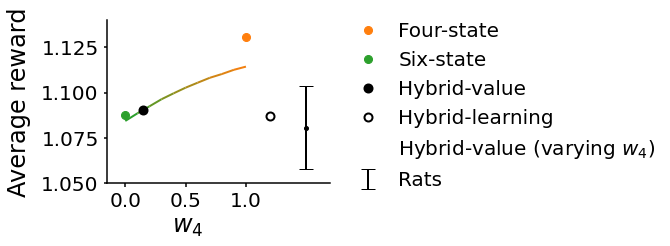

In [90]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.family': 'arial'})
lineWidth = 2
fontsize = 24
labelsize = 20
ylim=[1.05, 1.14]

fig, ax = plt.subplots(figsize=(4,3))

# simulation
ax.plot(1, avgR['fourState_full'], 'o', color='C1', linewidth=lineWidth, markersize=8, label='Four-state')
ax.plot(0, avgR['sixState_full'], 'o', color='C2', linewidth=lineWidth, markersize=8, label='Six-state')
ax.plot(w4_fit, avgR['hybridValue_full'], 'o', color='k', linewidth=lineWidth, markersize=8, markeredgewidth=2, label='Hybrid-value')
ax.plot(1.2, avgR['hybridLearning_full'], 'o', color='k', linewidth=lineWidth, markersize=8, fillstyle='none', markeredgewidth=2, label='Hybrid-learning')

from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(44/256, 255/256, N)
vals[:, 1] = np.linspace(160/256, 127/256, N)
vals[:, 2] = np.linspace(44/256, 14/256, N)
cmap = ListedColormap(vals)
x = np.array(w4List)
y = np.array([avgR['w4'+str(w4)] for w4 in w4List])
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(np.min(y), np.max(y))
lc = LineCollection(segments, cmap=cmap, norm=norm, color='w', label='Hybrid-value (varying $w_4$)')
lc.set_array(y)
lc.set_linewidth(lineWidth)
line = ax.add_collection(lc)

# animals
avgR_rat = np.array([avgR['rat'+str(rat)] for rat in ratList])
ax.errorbar(x=1.5, y=np.mean(avgR_rat), yerr=np.std(avgR_rat)/np.sqrt(len(ratList)), linestyle='', color='k', capsize=7, linewidth=lineWidth, label='Rats')
ax.plot(1.5, np.mean(avgR_rat), '.', color='k', markersize=8)

ax.set_xlabel('$w_4$         ', fontsize=fontsize)
ax.set_ylabel('Average reward', fontsize=fontsize, labelpad=10)
ax.tick_params(axis='both', width=1.5, pad=5, direction='out', labelsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.set(xlim=[-0.15,1.7], ylim=ylim)
ax.set(xticks=[0,0.5,1])

ax.legend(frameon=False, fontsize=labelsize, handletextpad=0.5, bbox_to_anchor=(1, 1.1))

plt.show()

### Learning curves


In [91]:
# simulation parameters
NSessions = 10000
NTrials = 57

In [92]:
run_simulation = False

curveData = dict.fromkeys(['w4'+str(w4) for w4 in w4List])
            
# hybrid-value model: w4 = 0 and 1
modelName = 'hybridValue_full'
for w4 in [0,1]:
    curveData['w4'+str(w4)] = get_simulated_data('curveData', modelName, w4, NSessions, run_simulation)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


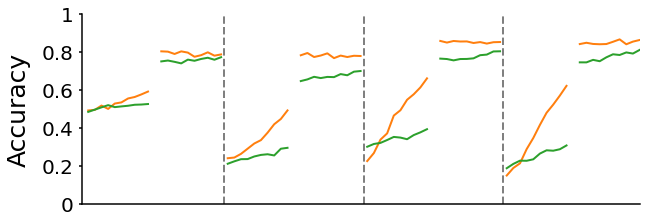

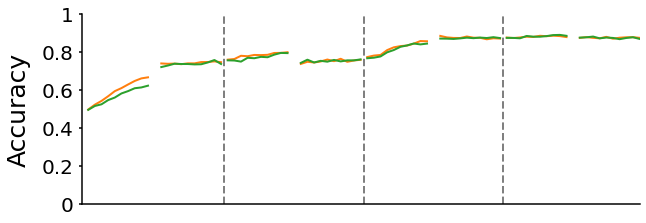

In [93]:
import pickle
n_blocks= 4
model = 'hybridValue_full'
modelLabels = ['Six-state', 'Four-state']

# plot setting
N = 10
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.family': 'arial'})
lineWidth = 2
    
for trialType in ['free', 'forced']:
    fig, ax = plt.subplots(figsize=(10,3.5))

    for w4 in [1, 0]:
        trialIndices = curveData['w4'+str(w4)][trialType, 'x']
        y = curveData['w4'+str(w4)][trialType, 'y']
        err = curveData['w4'+str(w4)][trialType, 'err']
        ax.plot(trialIndices, y, linewidth=lineWidth, color='C'+str(2-w4), label=modelLabels[w4], lineWidth=lineWidth)

    for blockChange in np.array([N*2+1, N*4+2, N*6+3])+0.5:
        ax.axvline(x=blockChange, linestyle='--', color='gray', linewidth=lineWidth)
    
    ax.set_ylim([0, 1])
    ax.set_xlim([0, N*8+4])
    ax.set_xlabel('Trial')
    ax.set_ylabel('Accuracy')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels('')
    ax.tick_params(axis='x', length=0)
    ax.set_xlabel('')
    ax.tick_params(axis='y', width=1.5, pad=5, direction='out')
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
    ax.set_ylabel('Accuracy', fontsize=25)
    ax.yaxis.labelpad = 10
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)